In [1]:
# IMPORTING THE REQUIRED LIBRARIES:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os
import cv2
import skimage

import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline 

# Ignore harmless warnings:

import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

import platform
print(torch.__version__)
print(platform.python_version())


1.8.1
3.6.10


In [2]:
torch.cuda.get_device_name(1)

'TITAN X (Pascal)'

In [3]:
# LOADING DATA: 30000 MOST COMMON ENGLISH WORDS

top_30000_words = pd.read_csv('30k.txt', delimiter = '\t', header = None)

words = []
sample_length = len(top_30000_words)

for i in range(sample_length):
    words.append(top_30000_words.loc[i][0])

total_length = len(words)

In [4]:
# FINDING PROBLEMATIC WORDS

huge_words = 0

for i in range(30000):
    if type(words[i]) == float:
        print(i)
        
    elif len(words[i]) > 15:
        words[i] = 'gavab'
        huge_words += 1
        #print(i)

words[2577] = 'null'
words[12819] = 'nan'
print(huge_words)

2577
12819
35


In [5]:
# DEFINING TRAINING, VALIDATION AND TEST SETS

train_set = words[0:28000]
val_set = words[28000:29000] 
test_set = words[29000:30000] 

MAX_LENGTH = max(len(list(word)) for word in words) # length of the longest word within our sample

print(MAX_LENGTH)
#print(test_set)

15


In [6]:
# ONE HOT ENCODING OF THE ALPHABET (+ START, END & PAD)

letters = ['START', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k',
          'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'END', 'PAD']


def letter_to_vector(letter):
    vector = torch.zeros(1, 1, len(letters))
    for i in range(len(letters)):
        if letters[i] == letter:
            vector[0, 0, i] = 1.
    return(vector)


print(letter_to_vector('PAD'))

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]])


In [7]:
# GETTING PATCH TENSOR FOR EACH WORD (PATCH, COLOR CHANNEL, HEIGHT, WIDTH)

def patch_gen(word, n_patches, patch_height, patch_width, stepsize):
    
    image = 255 * np.ones(shape = [height, width], dtype = np.uint8)
    image = cv2.putText(image, text = word, org = (5, 30),
        fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.62, color = (0, 0, 0),
        thickness = 1, lineType = cv2.LINE_AA)
    image = transforms.ToPILImage()(image) # np.ndarray to PIL.Image.Image
    patches_tensor = torch.empty(n_patches, color_channels, patch_height, patch_width)
    
    for p in range(n_patches):
        
        patch = transforms.functional.crop(image, 0, 0 + p * stepsize, patch_height, patch_width) # cropping of the image into patches
        patch = transforms.ToTensor()(patch) # torch.Tensor of the patch (normalized)
        #patch = skimage.util.random_noise(patch, mode='s&p') # we set some random noise to the image
        #patch = torch.from_numpy(patch) # conversion to pytorch tensor again
        patch = 1. - patch # it will work better if we have white text over black background
        patch = patch.view(1, 1, patch_height, patch_width) # CNN_model expects a 4-dimensional tensor (1 dimension for batch)
        patch = patch.type(torch.FloatTensor) # conversion to float
        patch = patch.cuda(1) # set to cuda
        patches_tensor[p, 0, :, :] = patch
        patches_tensor = patches_tensor.cuda(1)
        
    return patches_tensor

In [8]:
# SETTING IMAGE AND SLIDING WINDOW (PATCH) PARAMETERS

height = 48
width = 192
patch_height = 48
patch_width = 10
stepsize = 2
color_channels = 1
n_patches = int((width - patch_width)/stepsize + 1) 

In [9]:
# GETTING TUPLE (TENSOR WITH PATCHES, LABEL) FOR EACH WORD OF A GIVEN SET:

def complete_set(which_set):
    
    complete_set = []
    
    for word in which_set:
        
        complete_set.append((patch_gen(word, n_patches, patch_height, patch_width, stepsize), word))
        
    return complete_set

In [10]:
# TUPLE OF (RANK-4 TENSOR [PATCH, CHANNEL, HEIGHT, WIDTH], LABEL) FOR EVERY WORD IN EVERY SET

comp_train_set = complete_set(which_set = train_set)
comp_val_set = complete_set(which_set = val_set)
comp_test_set = complete_set(which_set = test_set)

In [11]:
# LOADING DATA AND SETS IN BATCHES

torch.manual_seed(123)

batch_size = 16

train_loader = DataLoader(comp_train_set, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(comp_val_set, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(comp_test_set, batch_size = batch_size, shuffle = False)


for image, label in train_loader:
    break
    
image_cnn = image.view(-1, color_channels, patch_height, patch_width)   
print(image.shape)
print(image_cnn.shape)
print(label)

torch.Size([16, 92, 1, 48, 10])
torch.Size([1472, 1, 48, 10])
('ff', 'invariably', 'massage', 'christie', 'refrigerator', 'better', 'fen', 'bhd', 'leader', 'typo', 'annan', 'rolls', 'xxl', 'exploring', 'rubbing', 'caregiver')


In [12]:
# GETTING ONE HOT TENSOR OF THE TARGET WORD

    # one hot tensor of the input batch of words for the Decoder:
    # 1 dim for position within batch, 1 dim for position of the letter in the fixed sequence (MAX_LENGTH + START + END),
    # 1 final dim specifying letter (output_size = 26 + START and END tokens)
    # torch.zeros() ensures that we always have PAD token vectors in case our target word is not MAX_LENGTH long
    # WARNING: only works if label contains 2 words or more (it is OK as long as we are doing batching)
    
def get_one_hot_target(label, batch, seq_len, output_size):
    
    one_hot_target = torch.zeros(batch, seq_len, output_size) 

    for j in range(batch): # for each word of the batch

        length = len(list(label[j])) # we compute the number of letters

        one_hot_target[j, 0, :] = letter_to_vector('START') # the first letter of every word will always be the START

        for k in range(0, length): # now for each letter of the target word

            target_letter = list(label[j])[k] # picks the 'k' target letter 
            one_hot_target[j, k + 1, :] = letter_to_vector(target_letter) # adds that one hot target letter to our global tensor

        one_hot_target[j, length + 1, :] = letter_to_vector('END') # we put END after the last letter of the word
        
        for m in range(length + 2, seq_len):
            
            one_hot_target[j, m, :] = letter_to_vector('PAD') # padding until the end of the sequence
        
    return one_hot_target        

In [13]:
# CONVERTS THE LOGSOFTMAX DECODER OUTPUT DURING EVALUATION TO THE CORRESPONDING ONE-HOT LETTER

def one_hot_conversion(decoder_output, output_size):
    
    one_hot_output_letter = torch.zeros(1, 1, output_size).cuda(1)
    index = torch.argmax(decoder_output, dim = 2).item()
    one_hot_output_letter[0, 0, index] = 1.
    
    return one_hot_output_letter

In [14]:
# DEFINING MODEL AND ARCHITECTURE

# CONVOLUTIONAL NEURAL NETWORK:

class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1, 2) # padding???
        self.conv2 = nn.Conv2d(20, 50, 5, 1, 2)
        self.fc1 = nn.Linear(12*2*50, 1024)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 12*2*50) # -1 para no tener que determinar aquí el tamaño del batch (se ajusta, podemos variarlo)
        #X = F.relu(self.fc1(X))
        X = self.fc1(X)

        return X 

In [15]:
# ENCODER:

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first = True)

    def forward(self, input, hidden, batch, seq_len):
        
        output = input.view(batch, seq_len, input_size)
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self, batch):
        return (torch.zeros(1, batch, self.hidden_size, device=device),
                torch.zeros(1, batch, self.hidden_size, device=device))

In [16]:
# DECODER:

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(output_size, hidden_size, batch_first = True)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 2) 
        # dim = 2 porque esta última dimensión es la correspondiente a output_size, que es sobre
        # la que queremos hacer el softmax

    def forward(self, input, hidden, batch, seq_len):
        
        output = input.view(batch, seq_len, output_size)
        #output = F.relu(output) # la relu se metía aquí porque en el
        #caso NLP del ejemplo de PyTorch previamente había una capa de embedding
        #No nos hace falta porque nuestro tensor de inputs ya es one-hot
        output, hidden = self.lstm(output, hidden)
        output = self.out(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, batch):
        return (torch.zeros(1, batch, self.hidden_size, device=device),
               torch.zeros(1, batch, self.hidden_size, device=device))

In [17]:
torch.manual_seed(123)

input_size = 1024
hidden_size = 256
output_size = 29

CNN_model = ConvolutionalNetwork().cuda(1)
CNN_optimizer = torch.optim.Adam(CNN_model.parameters(), lr = 0.001)

Encoder_model = EncoderRNN(input_size = input_size, hidden_size = hidden_size).cuda(1)
Encoder_optimizer = optim.SGD(Encoder_model.parameters(), lr = 0.001)

Decoder_model = DecoderRNN(hidden_size = hidden_size, output_size = output_size).cuda(1)
Decoder_optimizer = optim.SGD(Decoder_model.parameters(), lr = 0.001)

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()

In [18]:
# TRAINING THE MODEL:

import time
start_time = time.time()

# Tensorboard real time visualisation:

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

epochs = 5000

patience = 100
min_loss_val = 10 # huge initial value for the minimum validation loss

train_losses = []
val_losses = []

torch.manual_seed(123)

for i in range(epochs):
    
    for b, (image, label) in enumerate(train_loader):
        
        b += 1
        train_batch = len(label) # last batch may be of smaller, different size

        encoder_hidden = Encoder_model.initHidden(batch = train_batch)

        image_cnn = image.view(-1, color_channels, patch_height, patch_width).cuda(1)
        encoder_input = CNN_model(image_cnn)
        _, encoder_hidden = Encoder_model(encoder_input, encoder_hidden, batch = train_batch, seq_len = n_patches)

        decoder_hidden = encoder_hidden
        decoder_input = get_one_hot_target(label=label, batch = train_batch, seq_len = MAX_LENGTH + 2,
                                          output_size = output_size).cuda(1)
        decoder_output, decoder_hidden = Decoder_model(decoder_input, decoder_hidden,
                                                       batch = train_batch, seq_len = MAX_LENGTH + 2)

        output_indices = torch.tensor(list(range(0, MAX_LENGTH + 1))).cuda(1) # removing last token from the output
        decoder_output = torch.index_select(decoder_output, dim = 1, index = output_indices)

        ground_truth = torch.argmax(decoder_input, dim = 2)
        target_indices = torch.tensor(list(range(1, MAX_LENGTH + 2))).cuda(1) # remove SOS token from the input
        ground_truth = torch.index_select(ground_truth, dim = 1, index = target_indices)

        loss = 0
        
        for j in range(train_batch):
            
            loss += criterion(decoder_output[j], ground_truth[j])   
            
        loss = loss/train_batch
        
        
        CNN_optimizer.zero_grad()
        Encoder_optimizer.zero_grad()
        Decoder_optimizer.zero_grad()

        loss.backward()

        CNN_optimizer.step()
        Encoder_optimizer.step()
        Decoder_optimizer.step()
    
    
    with torch.no_grad():
        
        for v, (image_val, label_val) in enumerate(val_loader):
        
            v += 1
            val_batch = len(label_val)
            
            encoder_hidden_val = Encoder_model.initHidden(batch = val_batch)

            image_cnn_val = image_val.view(-1, color_channels, patch_height, patch_width).cuda(1)
            encoder_input_val = CNN_model(image_cnn_val)
            _, encoder_hidden_val = Encoder_model(encoder_input_val, encoder_hidden_val, batch = val_batch, seq_len = n_patches)

            decoder_hidden_val = encoder_hidden_val
            decoder_input_val = get_one_hot_target(label=label_val, batch = val_batch, seq_len = MAX_LENGTH + 2,
                                                  output_size = output_size).cuda(1)
            decoder_output_val, decoder_hidden_val = Decoder_model(decoder_input_val, decoder_hidden_val,
                                                                  batch = val_batch, seq_len = MAX_LENGTH + 2)
            
            output_indices_val = torch.tensor(list(range(0, MAX_LENGTH + 1))).cuda(1) # remove last token from the output
            decoder_output_val = torch.index_select(decoder_output_val, dim = 1, index = output_indices_val)

            ground_truth_val = torch.argmax(decoder_input_val, dim = 2)
            target_indices_val = torch.tensor(list(range(1, MAX_LENGTH + 2))).cuda(1) # remove START token from the input
            ground_truth_val = torch.index_select(ground_truth_val, dim = 1, index = target_indices_val)
            
            loss_val = 0
            
            for j in range(val_batch):
                
                loss_val += criterion(decoder_output_val[j], ground_truth_val[j])
            
            loss_val = loss_val/val_batch
        
        
    train_losses.append(loss)
    val_losses.append(loss_val)
    
    # Sending losses to Tensorboard: 
    writer.add_scalar('Loss/train', loss, i)
    writer.add_scalar('Loss/validation', loss_val, i)
    
    patience -= 1 # updating patience
    
    
    # Early Stopping procedure:
    
    if patience == 0: 
        
        break
    
    else:
        
        if loss_val < min_loss_val: # condition to save the best model

            min_loss_val = loss_val

            patience = 100

            # Saving best model so far:

            torch.save(CNN_model.state_dict(), 'CNN_model_30000_words_TF_PAD_2.pt')
            torch.save(Encoder_model.state_dict(), 'Encoder_model_30000_words_TF_PAD_2.pt')
            torch.save(Decoder_model.state_dict(), 'Decoder_model_30000_words_TF_PAD_2.pt')
        
    print(f'Epoch: {i}')
    
print(f'Duration: {(time.time() - start_time)/60} minutes')    

NameError: name 'train_loader' is not defined

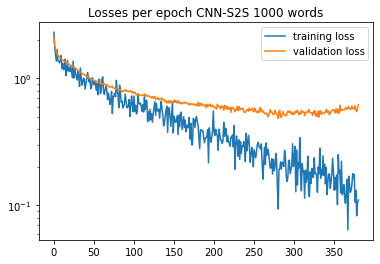

In [31]:
# Plotting results

plt.yscale("log")
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.title('Losses per epoch CNN-S2S 1000 words')
plt.legend();
#plt.savefig('1000 words training losses lr=0,001, bs=16')

In [33]:
CNN_model.load_state_dict(torch.load('CNN_model_30000_words_TF_PAD_2.pt'))
CNN_model.eval()

Encoder_model.load_state_dict(torch.load('Encoder_model_30000_words_TF_PAD_2.pt'))
Encoder_model.eval()

Decoder_model.load_state_dict(torch.load('Decoder_model_30000_words_TF_PAD_2.pt'))
Decoder_model.eval()

DecoderRNN(
  (lstm): LSTM(29, 256, batch_first=True)
  (out): Linear(in_features=256, out_features=29, bias=True)
  (softmax): LogSoftmax(dim=2)
)

In [34]:
with torch.no_grad():
 
    for t, (image_test, label_test) in enumerate(test_loader):

        t += 1
        test_batch = len(label_test)
        
        encoder_hidden_test = Encoder_model.initHidden(batch = test_batch)
        
        image_cnn_test = image_test.view(-1, color_channels, patch_height, patch_width).cuda(1)
        encoder_input_test = CNN_model(image_cnn_test)
        _, encoder_hidden_test = Encoder_model(encoder_input_test, encoder_hidden_test, batch = test_batch, seq_len = n_patches)
        
        for j in range(test_batch):
           
            decoder_input_test = letter_to_vector('START').cuda(1) # We initialize the first Decoder input as the START token

            decoder_hidden_test = (encoder_hidden_test[0][0, j, :].view(1, 1, hidden_size), # We take the last hidden state of the Encoder 
                                   encoder_hidden_test[1][0, j, :].view(1, 1, hidden_size)) # for each image/word (j) within the batch 
            # This would be the first hidden state of the Decoder for image/word (j)

            for d in range(MAX_LENGTH + 2):
                
                decoder_output_test, decoder_hidden_test = Decoder_model(decoder_input_test, decoder_hidden_test, 
                                                                         batch = 1, seq_len = 1)
                
                output_letter = one_hot_conversion(decoder_output_test, output_size = output_size)
                decoder_input_test = output_letter
                
                if d == 0:
                    
                    output_word = output_letter
                    
                else:
                    
                    output_word = torch.cat((output_word, output_letter), dim = 1).cuda(1)
                
                
                END_condition = torch.equal(output_letter, letter_to_vector('END').cuda(1))
                
                if  END_condition == True:
                    
                    break
            
            output_word = torch.argmax(output_word, dim=2)
            output_word = output_word.view(output_word.numel()) # view as a rank-1 tensor
            
            model_word = []


            for item in output_word:
                model_word.append(letters[item])

            model_word = ''.join(model_word[:-1])
            print(model_word)
            
print(test_set) 


gettiptipt
fifffyyif
genggpppf
geffspgfpy
ggggyysyPADPADPADPADPADPADPADPAD
giyyppyyyPADPADPADPADPADPADPAD
gggggof
engtippppyPADPADPADPADPADPAD
ggtgyyyyyPADPADPADPADPADPADPAD
attypptffyPADPADPADPADPADPAD
tyatgopggg
jtggpbypy
getypopp
giatppyyPADPADPADPADPADPADPADPAD
tyyyypyfPADPADPADPADPADPADPADPAD
bbctpippfPADPADPADPADPADPADPAD
gigtgpfppyPADPADPADPADPADPAD
gayyyyty
giffapifpg
tjagppyyyPADPADPADPADPADPADPAD
jaygappysyPADPADPADPADPADPAD
igattpff
gigtgympyPADPADPADPADPADPADPAD
gggtfppfppPADPADPADPADPADPAD
gaggogpsyPADPADPADPADPADPADPAD
iittgtpffpy
yatyppyft
igutbbpfffyPADPADPADPADPAD
gattppyyyyPADPADPADPADPADPAD
ggatypff
gitygtyyyyPADPADPADPADPADPAD
iggtppptfpyPADPADPADPADPAD
ghyppyyfyPADPADPADPADPADPADPAD
gigtagpgfyPADPADPADPADPADPAD
fayffpfyyyPADPADPADPADPADPAD
ggggtpfifyPADPADPADPADPADPAD
gghtbpffpyPADPADPADPADPADPAD
bttfshmspyPADPADPADPADPADPAD
igigyepff
gatybsssfyPADPADPADPADPADPAD
tatffpfit
igtbbobyyyyPADPADPADPADPAD
gigggppyyyPADPADPADPADPADPAD
gtafppts
gebpoppff
ggatggpcyy
btigpso

bhggtgpfffyPADPADPADPADPAD
gittgsspsyPADPADPADPADPADPAD
jttffppff
tubatspyyPADPADPADPADPADPADPAD
gtitppyyyy
btatyyyyyPADPADPADPADPADPADPAD
tifffpfyg
gbbbbopgyg
bbtppffffyyPADPADPADPADPAD
gyyyyysp
gbbbbpfof
bhgtbabcuf
ffatffifft
btstggpyyPADPADPADPADPADPADPAD
gggapfyyPADPADPADPADPADPADPADPAD
gngytycstf
yyyppyst
inatffpyyyPADPADPADPADPADPAD
ggatgpsfyyPADPADPADPADPADPAD
gittbbyfyy
gyyyyyppyPADPADPADPADPADPADPAD
gettghpipyyPADPADPADPADPAD
btggpfpfstPADPADPADPADPADPAD
tggfgyfti
gitggpyyyPADPADPADPADPADPADPAD
buutatffo
geggafoft
bugtippopi
nnggpptfyPADPADPADPADPADPADPAD
gefyfpttp
gagtoptogPADPADPADPADPADPADPAD
battgyfyyyPADPADPADPADPADPAD
ggeffffffyPADPADPADPADPADPAD
gttpppffsp
tyttboppy
ggggppppp
gegasgppy
titippsfyyyPADPADPADPADPAD
gytyyyyy
gggaptppstPADPADPADPADPADPAD
gayspfpfyPADPADPADPADPADPADPAD
iantgpppty
igtgtppffyPADPADPADPADPADPAD
ggigppyyyyPADPADPADPADPADPAD
ggttgyyyyyPADPADPADPADPADPAD
geffytypp
bittptopf
ggatipfft
bbttgppfgPADPADPADPADPADPADPAD
getggpfff
gigtyyyfyPADPADPADPADPAD

gbatfpyyyPADPADPADPADPADPADPAD
igtgpffst
ttittpffyyPADPADPADPADPADPAD
cifftpfpitPADPADPADPADPADPAD
titgggtfgg
gigtgpyyyPADPADPADPADPADPADPAD
giogygtyPADPADPADPADPADPADPADPAD
tyygyypopyPADPADPADPADPADPAD
giggfyyspsyPADPADPADPADPAD
gutggopyyPADPADPADPADPADPADPAD
ggatgpppf
gigtgffoff
gegbyappy
jtetffpfpyPADPADPADPADPADPAD
gitpppfystyPADPADPADPADPAD
gagtyyyy
jihbfypopyPADPADPADPADPADPAD
gtifppspy
giggpptypyPADPADPADPADPADPAD
bettffffyPADPADPADPADPADPADPAD
gttgtgfffPADPADPADPADPADPADPAD
gyatpoffp
gigttffff
gggtgtppyPADPADPADPADPADPADPAD
igngtpfyyyPADPADPADPADPADPAD
gggagppspyPADPADPADPADPADPAD
gttfagpf
ijsptpntyPADPADPADPADPADPADPAD
gigggpppffPADPADPADPADPADPAD
ggggtpopf
yyttyfpfyytPADPADPADPADPAD
gegsspfyyPADPADPADPADPADPADPAD
gggtpfop
giffptypfpyPADPADPADPADPAD
giggpeptfy
bugttppy
ggigppyppPADPADPADPADPADPADPAD
gantiptffyPADPADPADPADPADPAD
tiisppppyPADPADPADPADPADPADPAD
gefgppctfy
abtggtypyPADPADPADPADPADPADPAD
giggpyyy
bhbttppff
ggtyytoyyy
ggypypyyyPADPADPADPADPADPADPAD
yyytygyfy
ggappyy

In [ ]:
# activar pytorch_estoril (environment) en la terminal y ejecutar tensorboard --host 0.0.0.0 --logdir ./runs
# Tensorboard se ejecutará en un cierto puerto y nos dará el enlace. Habrá que sustituir la IP 0.0.0.0 por la del equipo
# en remoto en la que esté corriendo en el caso de Estoril 212.128.3.86:

In [23]:
test2 = words[20000:21000]
comp_test2 = complete_set(which_set = test2)
test2_loader = DataLoader(comp_test2, batch_size = batch_size, shuffle = False)

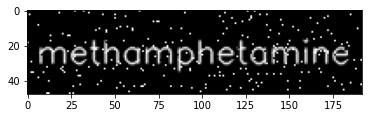

In [16]:
# EFFECT OF SALT & PEPPER

image = 255 * np.ones(shape = [height, width], dtype = np.uint8)
image = cv2.putText(image, text = 'methamphetamine', org = (5, 30),
    fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.62, color = (0, 0, 0),
    thickness = 1, lineType = cv2.LINE_AA)
image = transforms.ToPILImage()(image) 
image = transforms.ToTensor()(image)
image = skimage.util.random_noise(image, mode='s&p') # we set some random noise to the image
image = torch.from_numpy(image) # conversion to pytorch tensor again
image = 1. - image
image = transforms.ToPILImage()(image)
plt.imshow(image, cmap='gray')
